# Machine Learning 2025 Course - Homework
## MSc. in Bioinformatics and Computational Genomics
**Name:** Pardis Pourhamzeh
**Student ID:** 



In [1]:
import os
os.getcwd()
os.chdir('/Users/paradise/Downloads')

## 1. Load the Data & Preprocessing

We begin by loading the SUPPORT2 dataset and performing initial preprocessing:
- Drop variables related to previous models (`aps`, `sps`, `surv2m`, `surv6m`, `prg2m`, `prg6m`, `dnr`, `dnrday`), as recommended.
- Identify categorical variables and convert them to appropriate types.
- Inspect the dataset structure, summary statistics, and missing values.
- Impute missing values in key baseline variables (`alb`, `pafi`, `bili`, `crea`, `bun`, `wblc`, `urine`) with recommended defaults.


In [2]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("support2.csv")

# Drop variables as per Remark 1
drop_cols = ["aps", "sps", "surv2m", "surv6m", "prg2m", "prg6m", "dnr", "dnrday"]
df.drop(columns=drop_cols, inplace=True, errors='ignore')

# Identify categorical variables (example: gender, race, ca, income)
categorical_cols = df.select_dtypes(include='object').columns.tolist()
for col in categorical_cols:
    df[col] = df[col].astype('category')

# Impute missing baseline physiological variables (Remark 2)
impute_defaults = {
    "alb": 3.5,
    "pafi": 333.3,
    "bili": 1.01,
    "crea": 1.01,
    "bun": 6.51,
    "wblc": 9,
    "urine": 2502
}
df.fillna(value=impute_defaults, inplace=True)

# General inspection
df.head()
df.info()
df.describe()
missing = df.isnull().sum()
print(missing[missing > 0].sort_values(ascending=False))


<class 'pandas.core.frame.DataFrame'>
Index: 9105 entries, 1 to 9105
Data columns (total 39 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       9105 non-null   float64 
 1   death     9105 non-null   int64   
 2   sex       9105 non-null   category
 3   hospdead  9105 non-null   int64   
 4   slos      9105 non-null   int64   
 5   d.time    9105 non-null   int64   
 6   dzgroup   9105 non-null   category
 7   dzclass   9105 non-null   category
 8   num.co    9105 non-null   int64   
 9   edu       7471 non-null   float64 
 10  income    6123 non-null   category
 11  scoma     9104 non-null   float64 
 12  charges   8933 non-null   float64 
 13  totcst    8217 non-null   float64 
 14  totmcst   5630 non-null   float64 
 15  avtisst   9023 non-null   float64 
 16  race      9063 non-null   category
 17  hday      9105 non-null   int64   
 18  diabetes  9105 non-null   int64   
 19  dementia  9105 non-null   int64   
 20  ca        910

## 2. Target Variable Exploration

We analyze the distribution of the target variable for regression: **`totcst` (total cost)**.
We inspect its distribution, and analyze how `totcst` varies with categorical and numerical variables.


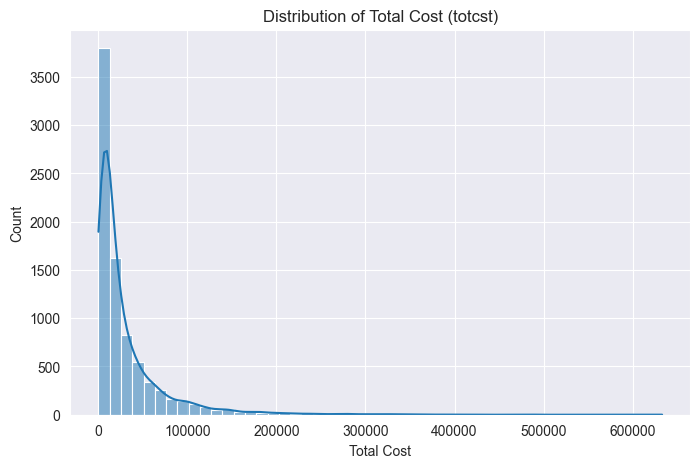

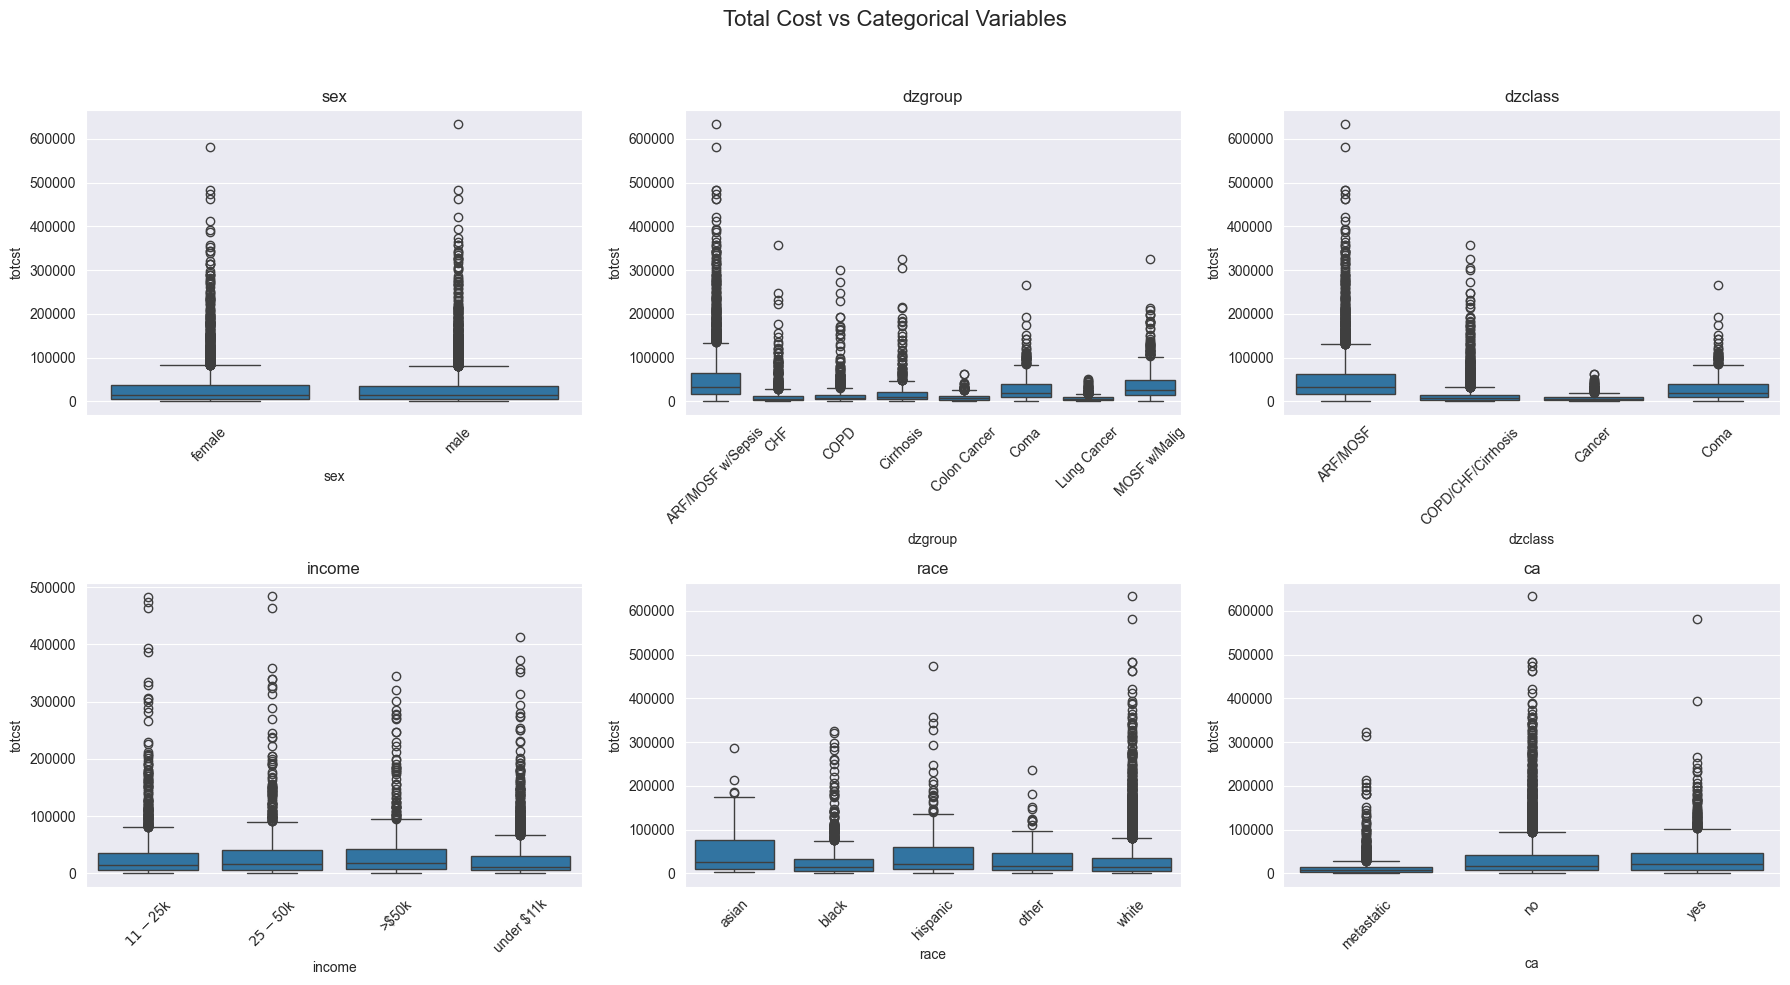

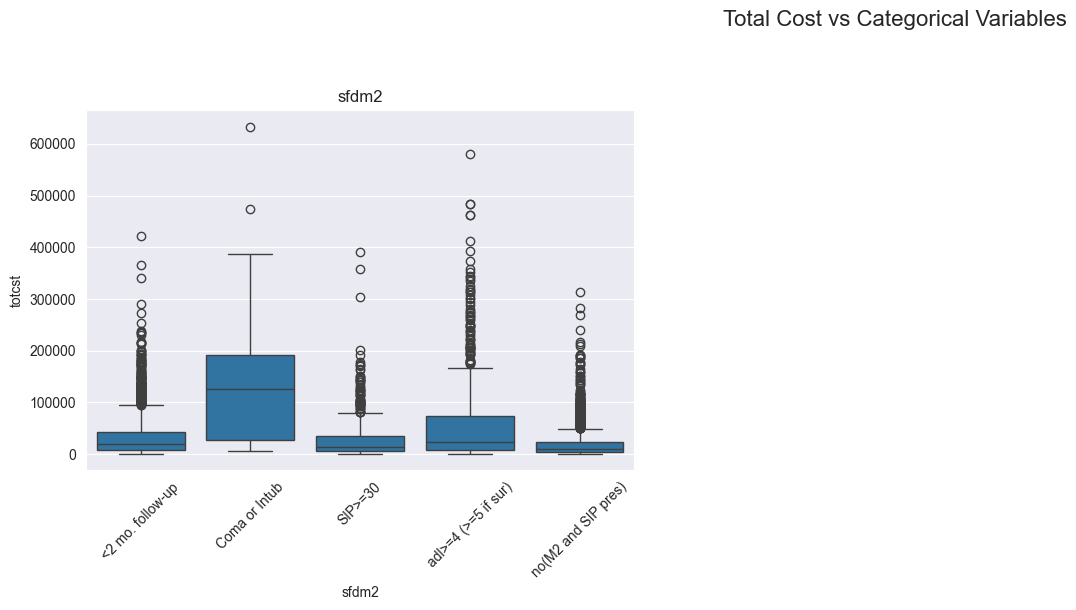

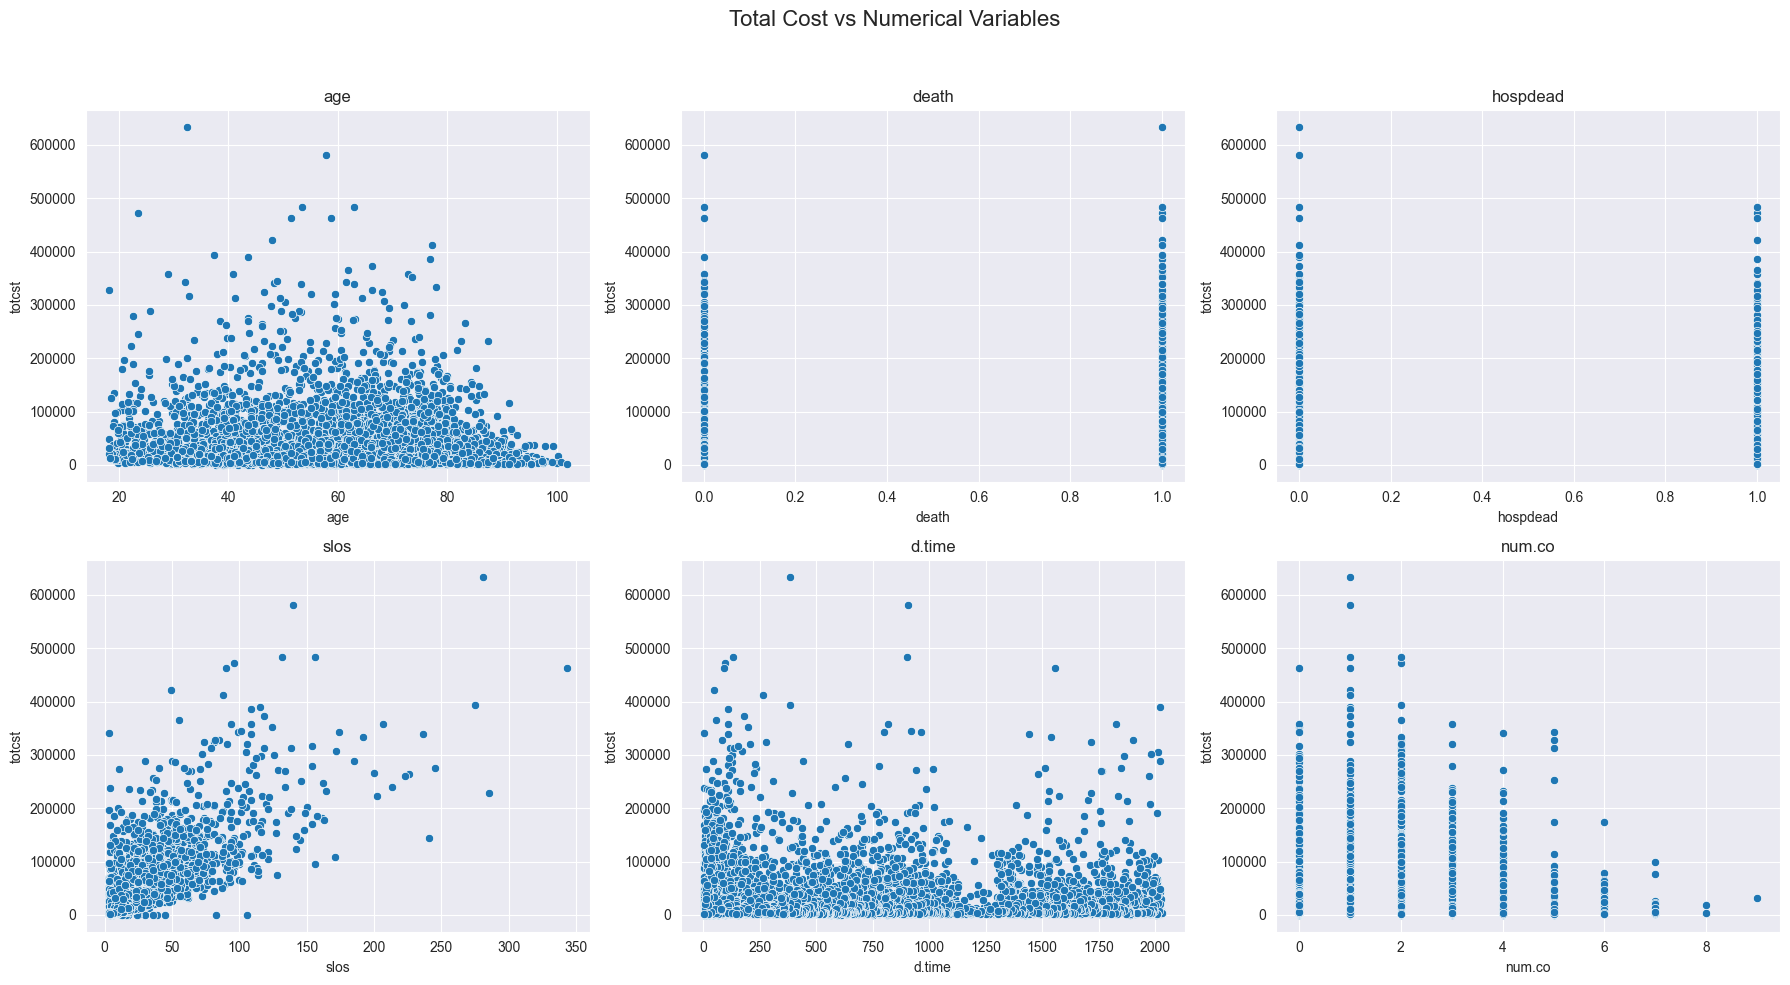

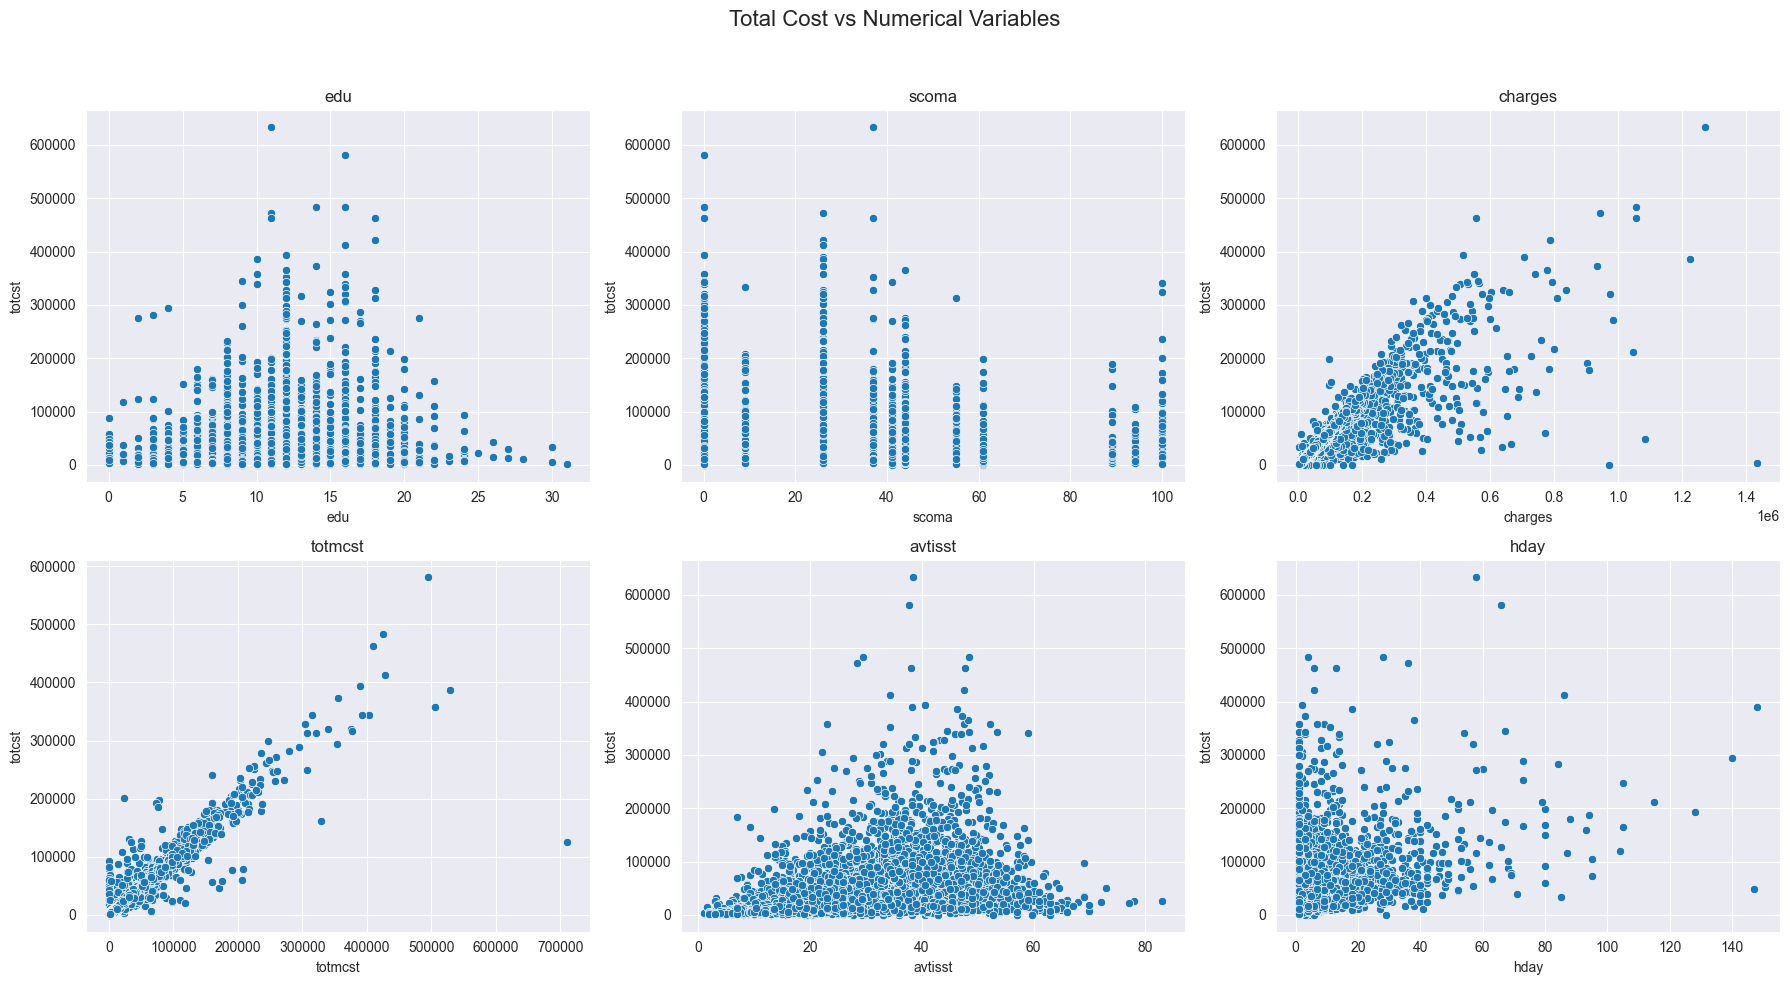

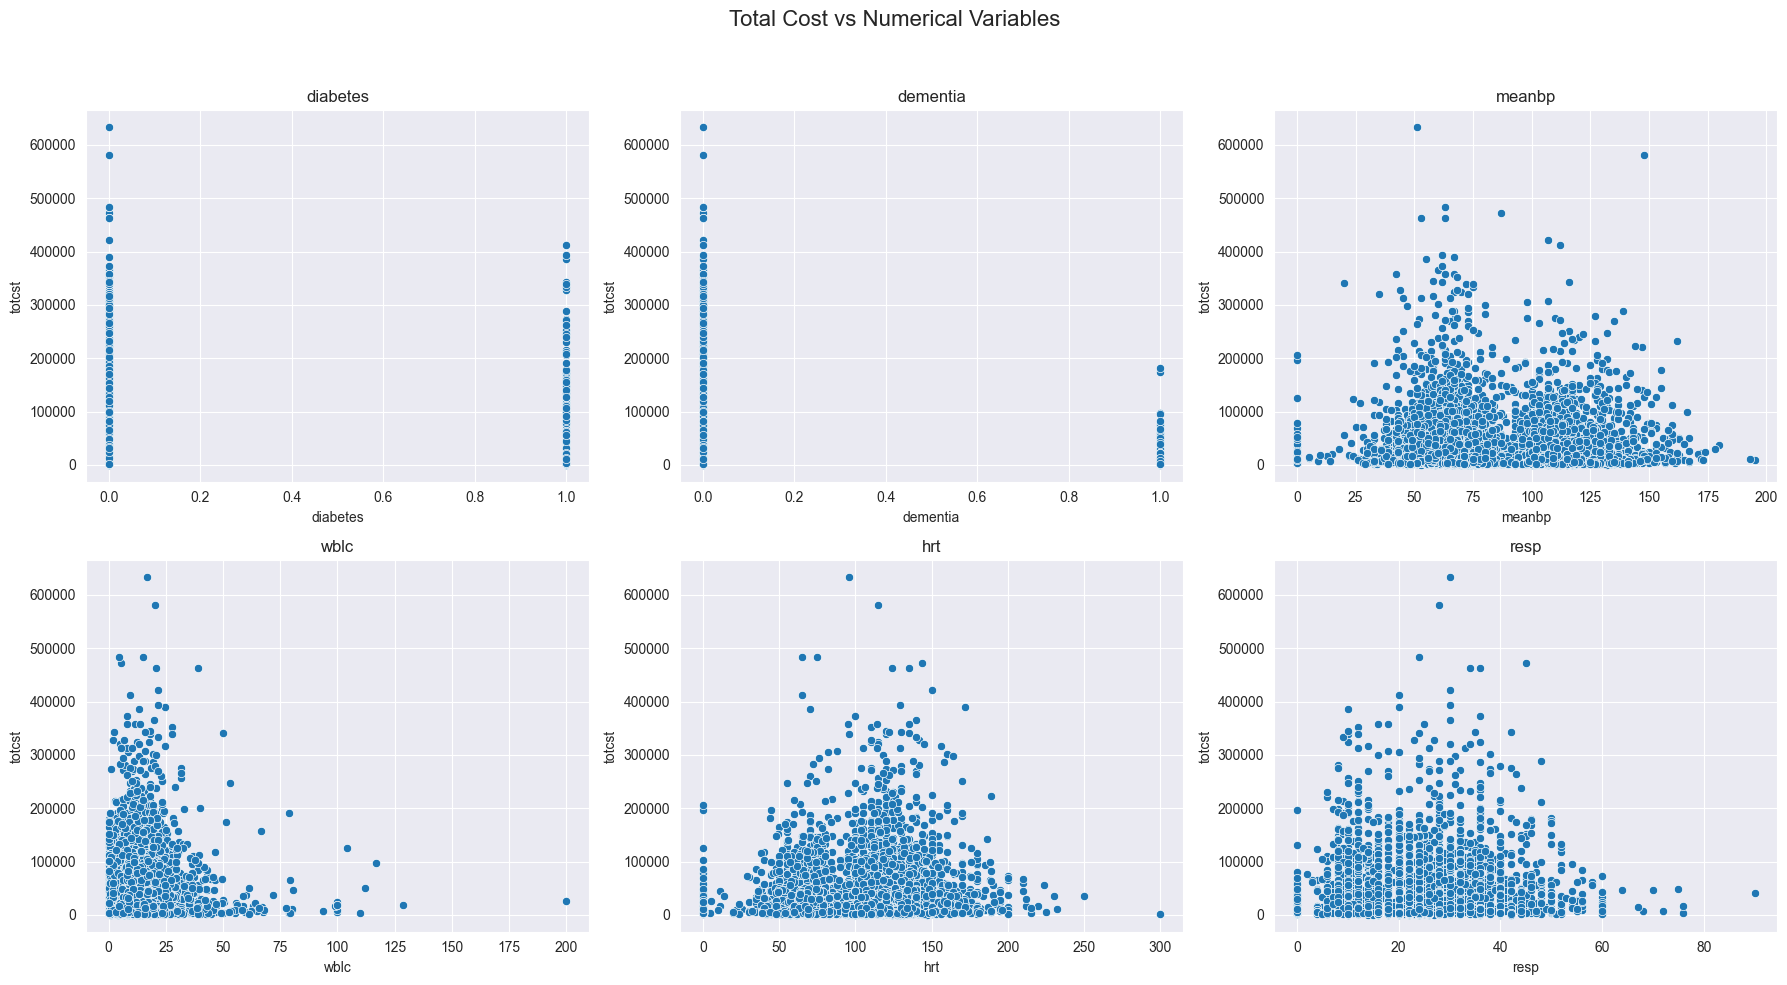

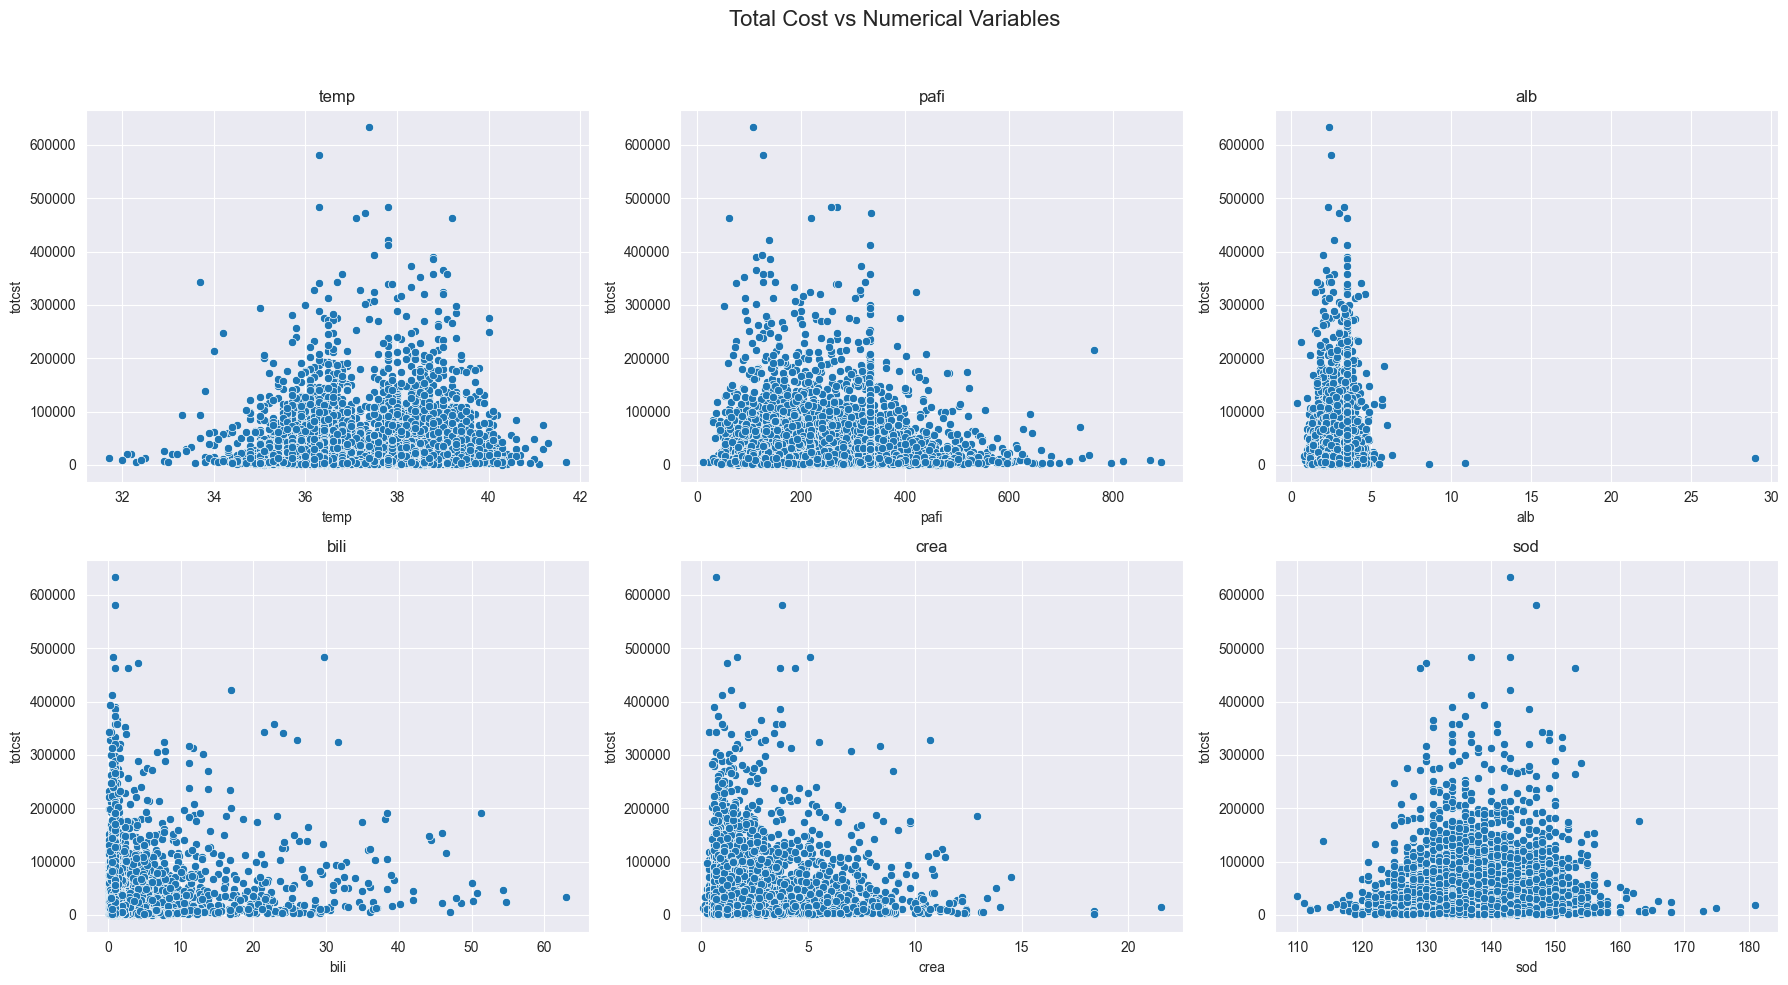

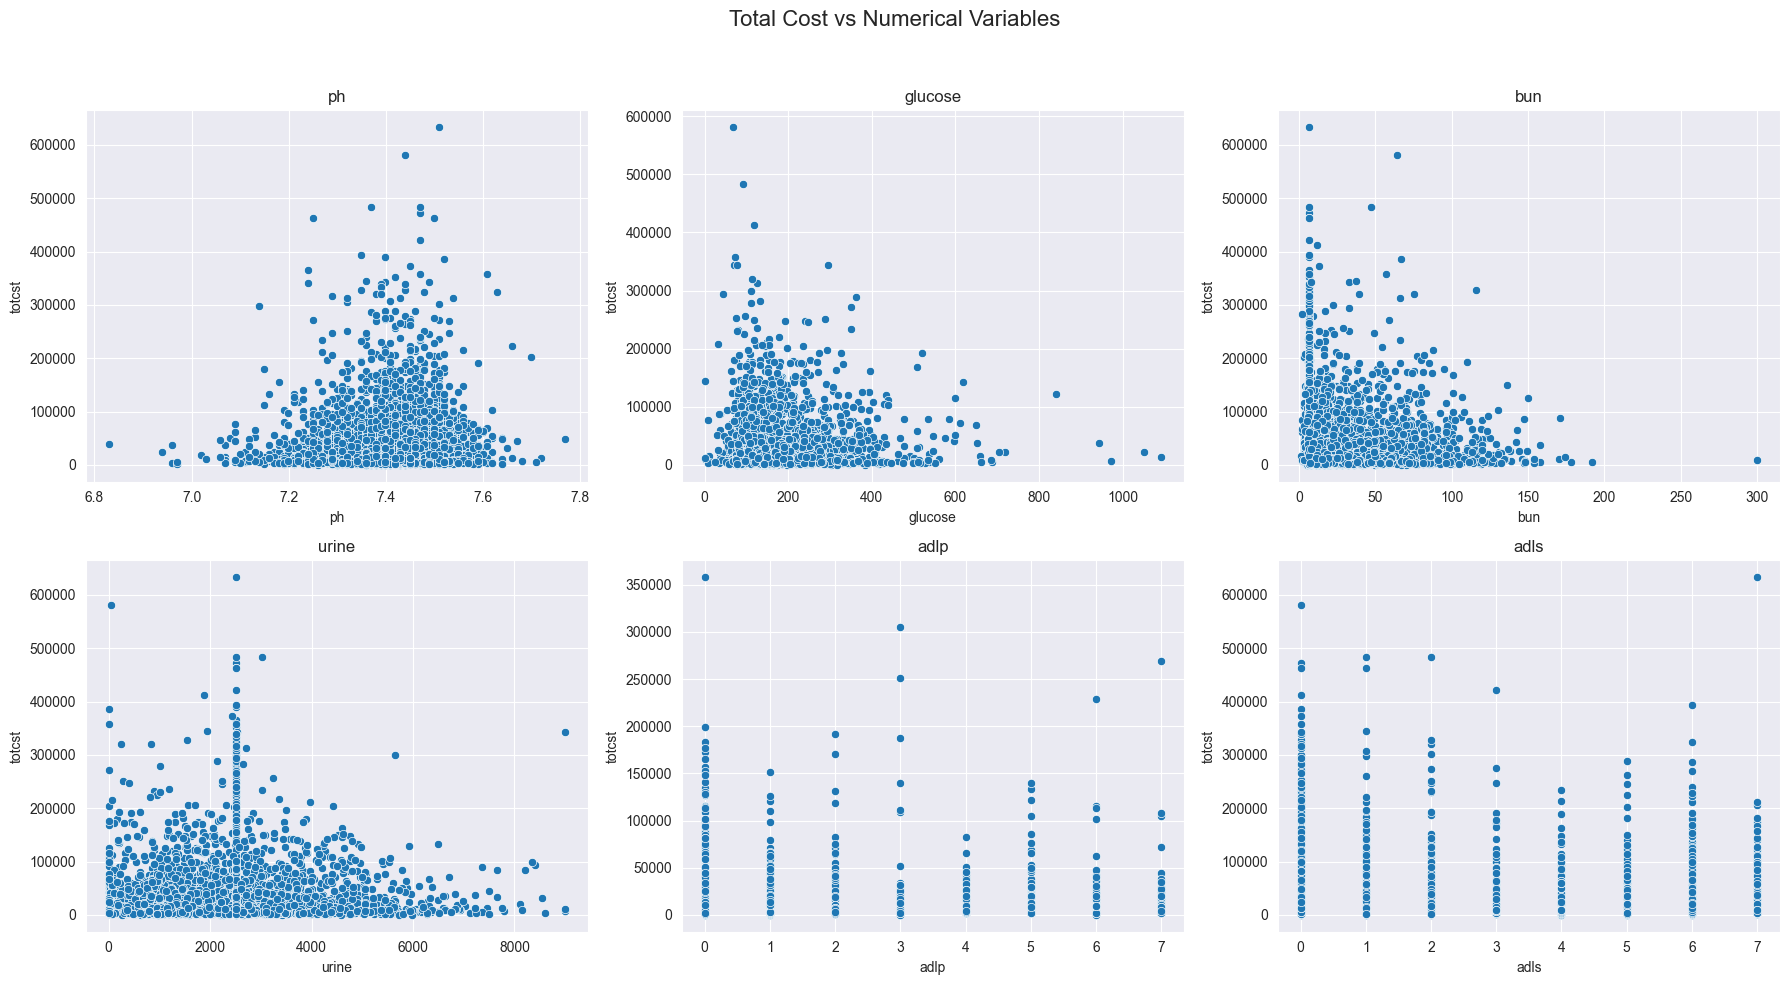

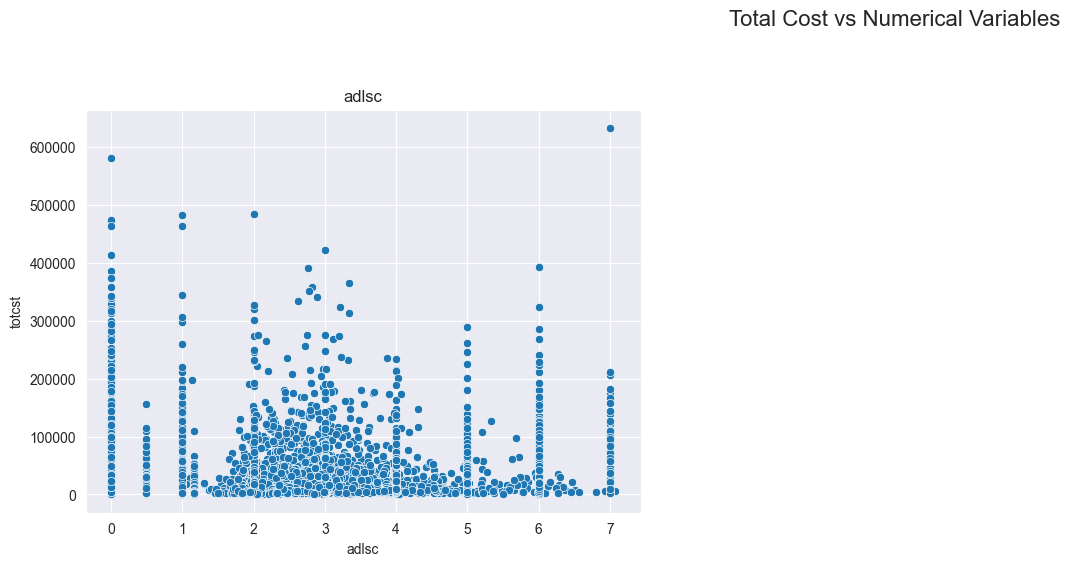

In [3]:
# Plot distribution of totcst
plt.figure(figsize=(8, 5))
sns.histplot(df['totcst'], bins=50, kde=True)
plt.title("Distribution of Total Cost (totcst)")
plt.xlabel("Total Cost")
plt.ylabel("Count")
plt.show()


# Total cost per category
# Set categorical columns
categorical_cols = df.select_dtypes(include='category').columns.tolist()

n_cols = 3   # plots per row
n_rows = 2   # rows per figure
plots_per_fig = n_cols * n_rows

for i in range(0, len(categorical_cols), plots_per_fig):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10))
    fig.suptitle("Total Cost vs Categorical Variables", fontsize=16)

    for j, col in enumerate(categorical_cols[i:i+plots_per_fig]):
        r = j // n_cols
        c = j % n_cols
        ax = axes[r, c]
        sns.boxplot(x=col, y='totcst', data=df, ax=ax)
        ax.set_title(col)
        ax.tick_params(axis='x', rotation=45)

    # Hide unused subplots
    total_plots = len(categorical_cols[i:i+plots_per_fig])
    for j in range(total_plots, plots_per_fig):
        r = j // n_cols
        c = j % n_cols
        fig.delaxes(axes[r, c])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# Total cost vs numerical variables
numerical_cols = df.select_dtypes(include=[np.number]).columns.drop('totcst')

for i in range(0, len(numerical_cols), plots_per_fig):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10))
    fig.suptitle("Total Cost vs Numerical Variables", fontsize=16)

    for j, col in enumerate(numerical_cols[i:i+plots_per_fig]):
        r = j // n_cols
        c = j % n_cols
        ax = axes[r, c]
        sns.scatterplot(x=col, y='totcst', data=df, ax=ax)
        ax.set_title(col)

    # Hide unused subplots
    total_plots = len(numerical_cols[i:i+plots_per_fig])
    for j in range(total_plots, plots_per_fig):
        r = j // n_cols
        c = j % n_cols
        fig.delaxes(axes[r, c])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



### 3. Objective: Correlation Exploration
In this section we explore the correlations between numerical and categorical variables in the dataset, focusing on potential multicollinearity issues and detecting strong relationships between features and the target. This helps us identify leakage, redundant features, and potential predictors for modeling.

We perform:
- Spearman’s correlation among numerical variables.
- Cramér’s V correlation among categorical variables.
- Analysis of significant correlations.
- A note on potential next steps (e.g., PCA) if needed.

### sfdm2: Ordinal Functional Disability

The `sfdm2` variable is the target for the clustering task.
It is ordinal categorical with the following values (in increasing severity):
- `no(M2 and SIP pres)`
- `SIP>=30`
- `adl>=4 (>=5 if sur)`
- `Coma or Intub`
- `<2 mo. follow-up` (patients with incomplete follow-up)

For now, we treat `sfdm2` as a categorical variable and exclude it from numerical analyses.
For clustering later, we will map these categories to ordinal integers to reflect the severity order.


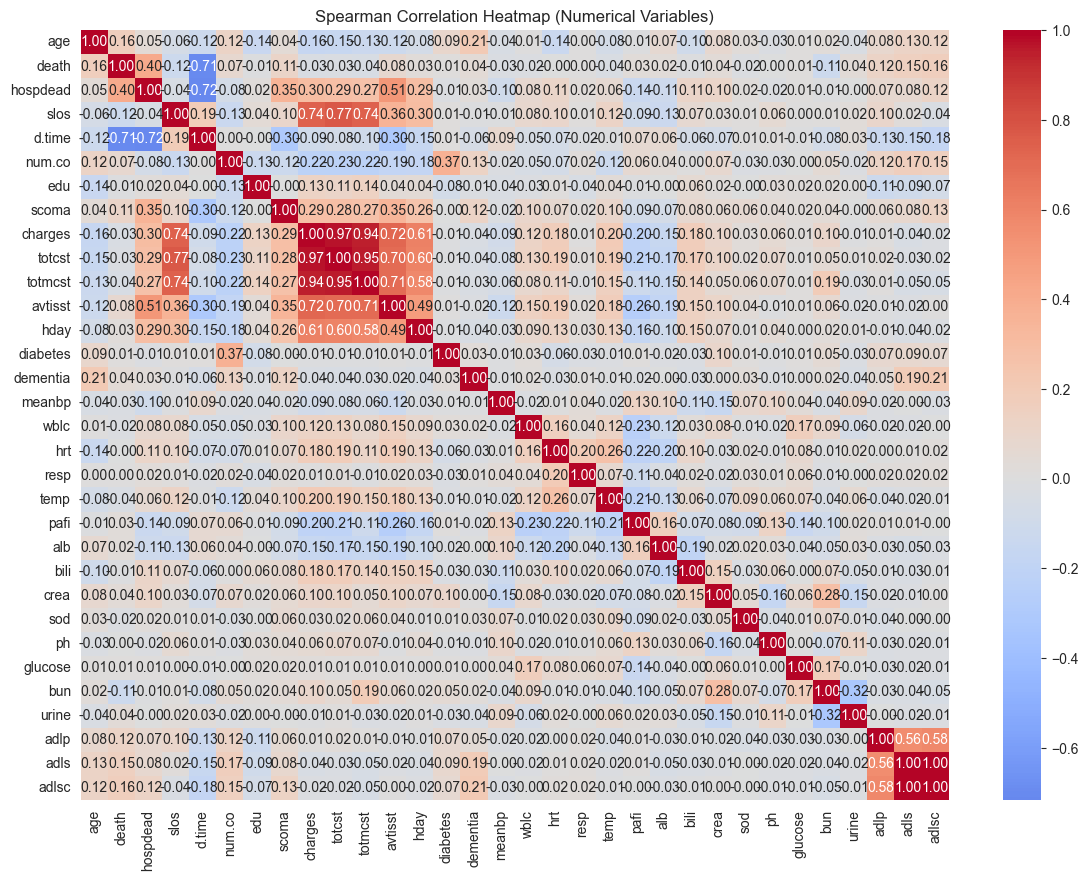

,Var1,Var2,SpearmanRho,p-value,absRho
308,adls,adlsc,1.000000,0.000000,1.000000
92,charges,totmcst,0.944954,0.000000,0.944954
45,slos,totmcst,0.740017,0.000000,0.740017
87,charges,slos,0.738667,0.000000,0.738667
112,avtisst,charges,0.718835,0.000000,0.718835
...,...,...,...,...,...
238,crea,resp,-0.020930,0.045827,0.020930
183,alb,death,0.020898,0.046150,0.020898
317,adlsc,charges,-0.020814,0.049161,0.020814
153,meanbp,num.co,-0.020753,0.047699,0.020753


In [4]:
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

# Select numerical columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Compute Spearman correlation and p-values
corr_matrix = pd.DataFrame(index=num_cols, columns=num_cols)
pval_matrix = pd.DataFrame(index=num_cols, columns=num_cols)

for col1 in num_cols:
    for col2 in num_cols:
        rho, p = spearmanr(df[col1], df[col2], nan_policy='omit')
        corr_matrix.loc[col1, col2] = rho
        pval_matrix.loc[col1, col2] = p

corr_matrix = corr_matrix.astype(float)
pval_matrix = pval_matrix.astype(float)

# Plot Spearman Correlation Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Spearman Correlation Heatmap (Numerical Variables)")
plt.show()

# Significant correlations
significant = []
for col1 in numerical_cols:
    for col2 in numerical_cols:
        if col1 < col2:  # avoid duplicates
            rho = corr_matrix.loc[col1, col2]
            pval = pval_matrix.loc[col1, col2]
            if pval < 0.05:
                significant.append((col1, col2, rho, pval))

sig_df = pd.DataFrame(significant, columns=['Var1', 'Var2', 'SpearmanRho', 'p-value'])
sig_df['absRho'] = sig_df['SpearmanRho'].abs()
sig_df.sort_values(by='absRho', ascending=False, inplace=True)

display(sig_df)


# Significance Analysis of Spearman Correlation
### Notes:
- Positive Rho close to +1 indicates strong positive monotonic correlation.
- Negative Rho close to -1 indicates strong negative monotonic correlation.
- Rho near 0 suggests no monotonic relationship.
- Extremely high Rho values (>0.95) likely indicate redundancy or leakage. We already removed known leakage variables to avoid cheating in prediction tasks.


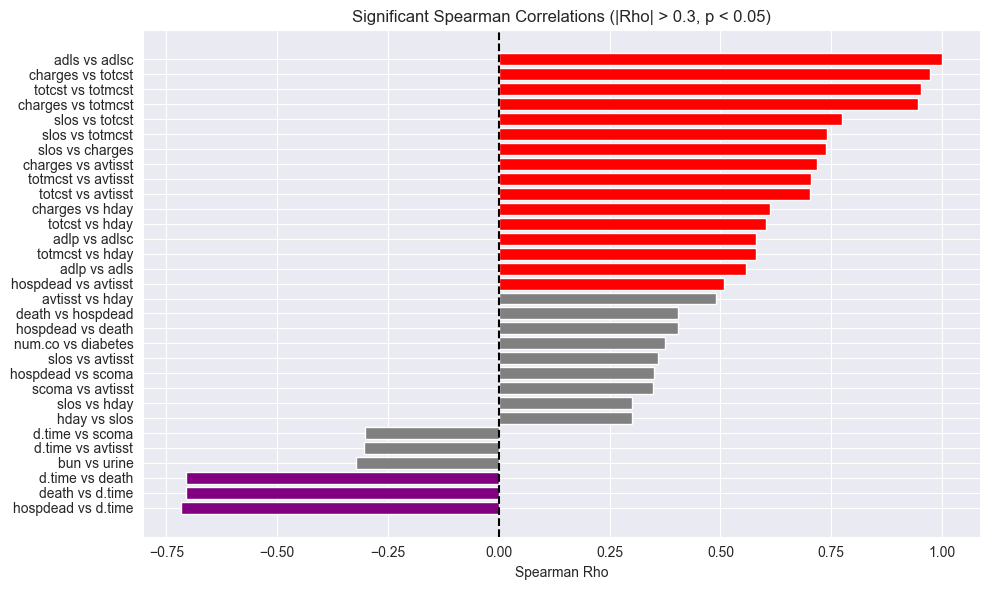

In [5]:
# Flattened pairs with significance info
flat_corrs = []

for col1 in num_cols:
    for col2 in num_cols:
        if col1 != col2:
            rho = corr_matrix.loc[col1, col2]
            pval = pval_matrix.loc[col1, col2]
            flat_corrs.append((col1, col2, rho, pval))

# Create DataFrame
flat_corr_df = pd.DataFrame(flat_corrs, columns=["Var1", "Var2", "Rho", "Pval"])
flat_corr_df = flat_corr_df.drop_duplicates(subset=['Rho'])  # Remove duplicates

# Keep significant ones
significant = flat_corr_df[(flat_corr_df["Pval"] < 0.05) & (flat_corr_df["Rho"].abs() > 0.3)]

# Sort and plot
significant_sorted = significant.sort_values("Rho")

plt.figure(figsize=(10, 6))
colors = significant_sorted["Rho"].apply(lambda r: "purple" if r < -0.5 else ("red" if r > 0.5 else "gray"))
plt.barh(
    significant_sorted["Var1"] + " vs " + significant_sorted["Var2"],
    significant_sorted["Rho"],
    color=colors
)
plt.title("Significant Spearman Correlations (|Rho| > 0.3, p < 0.05)")
plt.xlabel("Spearman Rho")
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


## 🔍 Cramér’s V Correlation of Categorical Variables

We use Cramér’s V to assess the association between categorical variables. This helps us check for redundant categorical predictors.
###  Notes:
- Cramér’s V ranges from 0 (no association) to 1 (perfect association).
- High values suggest redundancy between categorical features.


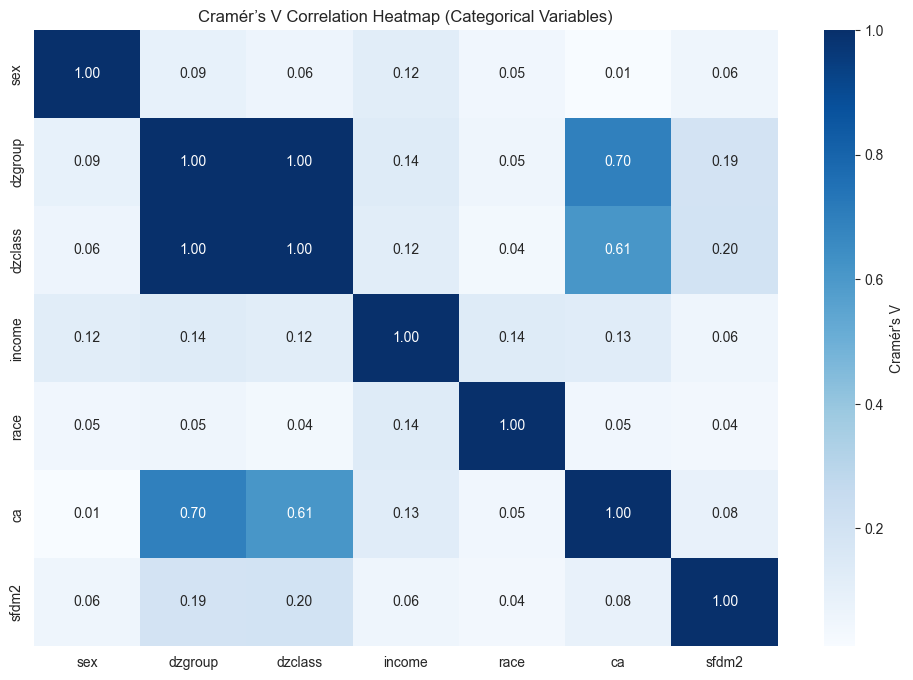

In [6]:
from scipy.stats import chi2_contingency
import numpy as np

# Function to compute Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Get categorical columns
cat_cols = df.select_dtypes(include='category').columns.tolist()

# Initialize correlation matrix
cramer_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols)

for col1 in cat_cols:
    for col2 in cat_cols:
        if col1 == col2:
            cramer_matrix.loc[col1, col2] = 1.0
        else:
            cramer_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

cramer_matrix = cramer_matrix.astype(float)

#Plot the heatmap of Cramér’s V
plt.figure(figsize=(12, 8))
sns.heatmap(cramer_matrix, annot=True, cmap='Blues', fmt=".2f", cbar_kws={'label': "Cramér's V"})
plt.title("Cramér’s V Correlation Heatmap (Categorical Variables)")
plt.show()

 # Correlation of `totcst` with numerical variables

In [7]:
from scipy.stats import spearmanr

# Prepare list of numerical variables excluding the target
num_cols_no_target = [col for col in num_cols if col != 'totcst']

# Compute Spearman rho and p-values for each variable vs totcst
results = []
for col in num_cols_no_target:
    rho, pval = spearmanr(df[col], df['totcst'], nan_policy='omit')
    results.append((col, rho, pval))

# Put into DataFrame
totcst_corrs = pd.DataFrame(results, columns=['Variable', 'SpearmanRho', 'PValue'])

# Filter significant correlations
significant_totcst_corrs = totcst_corrs[(totcst_corrs['PValue'] < 0.05) & (totcst_corrs['SpearmanRho'].abs() > 0.3)]
significant_totcst_corrs = significant_totcst_corrs.sort_values(by='SpearmanRho')

# Show results
print(significant_totcst_corrs)


   Variable  SpearmanRho  PValue
11     hday     0.603107     0.0
10  avtisst     0.703124     0.0
3      slos     0.774621     0.0
9   totmcst     0.953826     0.0
8   charges     0.972955     0.0


<b> Note:<b>

If two variables (`charges, totmcst`) are already extremely highly correlated with the target (`totcst`), they might actually just be leakage, because
they measure essentially the same thing.

So:

`charges, totmcst` and `totcst` are essentially different accounting summaries of the same underlying cost.

Including charges or totmcst to predict totcst is therefore cheating: it doesn’t teach the model anything meaningful; it just re-uses the answer.

we droped `charges` and `totmcst` from the predictive model of `totcst`

<div align="center">

# Regression for the Variable `totcst`

</div>

# Step 1: Preprocessing SUPPORT2 Dataset

Since we only have the SUPPORT2 dataset, we begin by identifying rows where the target variable `totcst` is missing. These rows will be saved separately for later imputation.

The main modeling dataset will exclude those missing target rows.

We also convert relevant categorical columns to the `category` datatype for appropriate processing later.


In [8]:
# Check total shape
print("SUPPORT2 shape:", df.shape)

# Identify rows with missing target 'totcst'
na_df = df[df['totcst'].isna()].copy()
df_model = df[df['totcst'].notna()].copy()

print("Rows with missing target (totcst):", na_df.shape[0])
print("Rows for modeling:", df_model.shape[0])



SUPPORT2 shape: (9105, 39)
Rows with missing target (totcst): 888
Rows for modeling: 8217


In [9]:
# 1. Identify categorical columns
cat_cols = df_model.select_dtypes(include='category').columns.tolist()
print(f"Categorical columns: {cat_cols}")

# 2. Check frequency of levels for each categorical column
rare_levels = {}

for col in cat_cols:
    freq = df_model[col].value_counts(normalize=True)
    rare = freq[freq < 0.01]  # less than 1%
    if not rare.empty:
        rare_levels[col] = rare.index.tolist()

print("Rare levels (freq < 1%) per categorical column:")
for col, levels in rare_levels.items():
    print(f" - {col}: {levels}")

# 3. Boolean columns to int (if any)
bool_cols = df_model.select_dtypes(include='bool').columns.tolist()
print(f"Boolean columns: {bool_cols}")

for col in bool_cols:
    df_model[col] = df_model[col].astype(int)
    na_df[col] = na_df[col].astype(int)


Categorical columns: ['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca', 'sfdm2']
Rare levels (freq < 1%) per categorical column:
 - race: ['asian']
 - sfdm2: ['Coma or Intub']
Boolean columns: []


## Notes:
Keep the NaNs as a separate category encoded as -1. This preserves all data and explicitly marks missingness, which many models can handle well.
* Now `sfdm2_ord` has values: -1, 0, 1, 2, 3, 4.
* -1 means missing severity.
* We drop the original sfdm2 (categorical) so that it doesn’t get one-hot encoded later.

In [10]:
# Ordinal mapping for sfdm2
df_model['sfdm2_clean'] = df_model['sfdm2'].astype(str).str.strip()

# Clean up sfdm2
df_model['sfdm2_clean'] = df_model['sfdm2'].astype(str).str.strip()

# Replace 'nan' strings (from .astype(str)) with actual NaN
df_model['sfdm2_clean'] = df_model['sfdm2_clean'].replace('nan', np.nan)

# Optionally fill missing with a category
df_model['sfdm2_clean'] = df_model['sfdm2_clean'].fillna('Missing')

sfdm2_ord_map = {
    'Missing': -1,
    '<2 mo. follow-up': 0,
    'no(M2 and SIP pres)': 1,
    'adl>=4 (>=5 if sur)': 2,
    'SIP>=30': 3,
    'Coma or Intub': 4
}
df_model['sfdm2_ord'] = df_model['sfdm2_clean'].map(sfdm2_ord_map)


# Mark categorical columns
categorical_cols = ['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca']
df_model[categorical_cols] = df_model[categorical_cols].astype("category")

# Drop leakage columns and the original sfdm2 column, since we encoded it
df_model = df_model.drop(columns=["totmcst", "charges"])
df_model.drop(columns=['sfdm2', 'sfdm2_clean'], inplace=True)
print(df_model[['sfdm2_ord']].value_counts().sort_index())



sfdm2_ord
-1           1275
 0           2797
 1           2773
 2            818
 3            521
 4             33
Name: count, dtype: int64


In the earlier step, we split the dataset into:
* df_model — the rows where `totcst` is not null (target is known).
* df_na — the rows where `totcst` is null (to predict later).

So to define X and y, we should extract the target (`totcst`) from df_model properly.

In [11]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer

X = df_model.drop(columns=["totcst"])
y = df_model["totcst"]

# one-hot encoded with drop="first" + handle_unknown="ignore, so missing categories are handled implicitly
ohe = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
X_cat = pd.DataFrame(ohe.fit_transform(X[categorical_cols]),
                     columns=ohe.get_feature_names_out(categorical_cols),
                     index=X.index)

X_num = X.drop(columns=categorical_cols)
X_num["sfdm2_ord"] = df_model["sfdm2_ord"]


num_cols = X_num.columns.tolist()
imp_num = SimpleImputer(strategy="median")
X_num_imputed = pd.DataFrame(
    imp_num.fit_transform(X_num),
    columns=num_cols,
    index=X_num.index
)

X_encoded = pd.concat([X_num_imputed, X_cat], axis=1)
print(f"Shape before variance selection: {X_encoded.shape}")

# Variance selection
vt = VarianceThreshold(threshold=0.01)
X_selected = pd.DataFrame(
    vt.fit_transform(X_encoded),
    columns=X_encoded.columns[vt.get_support()],
    index=X_encoded.index
)

print(f"Shape after variance selection: {X_selected.shape}")


Shape before variance selection: (8217, 52)
Shape after variance selection: (8217, 50)


### Improve feature engineering
Assess distributions and skew:
* Target: totcst
* Also log-transform highly skewed predictors, such as:

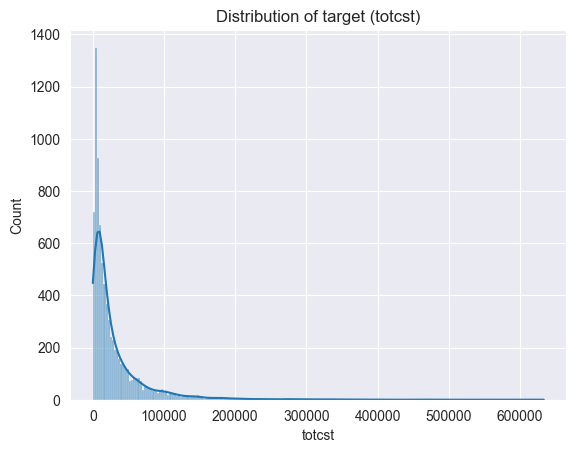

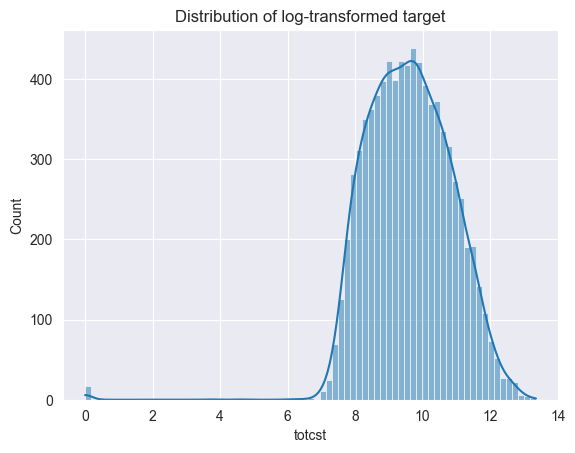

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.histplot(y, kde=True)
plt.title("Distribution of target (totcst)")
plt.show()

y_log = np.log1p(y)  # log(1+y) to avoid log(0)

sns.histplot(y_log, kde=True)
plt.title("Distribution of log-transformed target")
plt.show()


 We had 52 features after one-hot encoding, and after removing near-constant columns (low variance), we’re down to 50 features.

That means two dummy variables were so rare that they added no real information and got dropped.

 ## Fit Linear Full Model using Scikit Learn.
* All variance-selected features (≈ 50) used
* Get the coefficients for this complete model. Evalute the R2 and the MSE.

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Fit linear regression
linreg = LinearRegression()
linreg.fit(X_selected, y)

# Predictions on training set
y_pred = linreg.predict(X_selected)

# Training set R² and MSE
r2_train = r2_score(y, y_pred)
mse_train = mean_squared_error(y, y_pred)

print(f"Training R²: {r2_train:.3f}")
print(f"Training MSE: {mse_train:.2f}")

# Coefficients
coef_df = pd.DataFrame({
    "feature": X_selected.columns,
    "coefficient": linreg.coef_
}).sort_values(by="coefficient", key=abs, ascending=False)

print("\nTop 20 coefficients by magnitude:")
print(coef_df.head(20))


Training R²: 0.759
Training MSE: 504181086.99

Top 20 coefficients by magnitude:
                 feature  coefficient
44            race_black -7105.339245
47            race_white -6085.743140
2               hospdead  5039.125876
34          dzgroup_Coma -4906.167777
39          dzclass_Coma -4906.167777
36  dzgroup_MOSF w/Malig -4532.262160
41          income_>$50k  4234.213151
11              dementia -3397.916064
42     income_under $11k -2950.167333
1                  death -1927.115808
18                   alb  1759.029585
30           dzgroup_CHF  1747.935063
3                   slos  1441.307714
31          dzgroup_COPD -1388.464382
9                   hday  1336.038060
48                 ca_no  1068.206815
26                  adls -1065.205974
45         race_hispanic  1042.409566
29              sex_male  -864.198388
33  dzgroup_Colon Cancer  -765.351760


Notes:
* The R2 and MSE here are on training data, so expect R²train > R²CV (CV is more realistic).
* The coefficients tell you which variables are most impactful (positive or negative).
* We keep coef_df for later comparison with LASSO and SFS.

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lm = LinearRegression()
scores = cross_val_score(lm, X_selected, y, cv=5, scoring="r2")
print(f"Linear Regression CV R²: {scores.mean():.3f} ± {scores.std():.3f}")


Linear Regression CV R²: 0.711 ± 0.096


### Library stats model
* to produce a model and exploit the statsmodel function that are more inference-friendly
* perform a t-test and some other descrptive tests on the complete model (built with stats models).
* print the results for the complete model.

In [14]:
import statsmodels.api as sm

X_sm = sm.add_constant(X_selected)
model_sm = sm.OLS(y, X_sm).fit()
print(model_sm.summary())


                            OLS Regression Results                            
Dep. Variable:                 totcst   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     548.6
Date:                Thu, 10 Jul 2025   Prob (F-statistic):               0.00
Time:                        12:57:56   Log-Likelihood:                -93987.
No. Observations:                8217   AIC:                         1.881e+05
Df Residuals:                    8169   BIC:                         1.884e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)


## Lasso reg

In [34]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(cv=5)
lasso_cv.fit(X_scaled, y)

print(f"Best alpha: {lasso_cv.alpha_}")

#get selected features
lasso_selected_features = X_selected.columns[lasso_cv.coef_ != 0].tolist()
print(f"LASSO selected {len(lasso_selected_features)} features:")
print(lasso_selected_features)


# Residuals
y_pred_lasso = lasso_cv.predict(X_scaled)
residuals_lasso = y - y_pred_lasso


Best alpha: 202.24422001415402
LASSO selected 35 features:
['age', 'death', 'hospdead', 'slos', 'd.time', 'num.co', 'edu', 'avtisst', 'hday', 'diabetes', 'dementia', 'meanbp', 'hrt', 'resp', 'temp', 'alb', 'bili', 'crea', 'sod', 'glucose', 'adlp', 'adls', 'sex_male', 'dzgroup_CHF', 'dzgroup_COPD', 'dzgroup_Colon Cancer', 'dzgroup_Coma', 'dzgroup_MOSF w/Malig', 'dzclass_Coma', 'income_>$50k', 'income_under $11k', 'race_black', 'race_hispanic', 'race_other', 'ca_no']


## Lasso reg higher lower alpa

#from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(alphas=np.logspace(-4, 4, 200), cv=10)
lasso_cv.fit(X_selected, y)
print(f"Best alpha: {lasso_cv.alpha_}")


#get selected features
lasso_selected_features = X_selected.columns[lasso_cv.coef_ != 0].tolist()
print(f"LASSO selected {len(lasso_selected_features)} features:")
print(lasso_selected_features)

# Residuals
y_pred_lasso = lasso_cv.predict(X_selected)
residuals_lasso = y - y_pred_lasso

In [16]:
#from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(alphas=np.logspace(-4, 4, 200), cv=10)
lasso_cv.fit(X_selected, y)
print(f"Best alpha: {lasso_cv.alpha_}")


#get selected features
lasso_selected_features = X_selected.columns[lasso_cv.coef_ != 0].tolist()
print(f"LASSO selected {len(lasso_selected_features)} features:")
print(lasso_selected_features)

# Residuals
y_pred_lasso = lasso_cv.predict(X_selected)
residuals_lasso = y - y_pred_lasso


Best alpha: 18.464249428955426
LASSO selected 45 features:
['age', 'death', 'hospdead', 'slos', 'd.time', 'num.co', 'edu', 'scoma', 'avtisst', 'hday', 'diabetes', 'dementia', 'meanbp', 'wblc', 'hrt', 'resp', 'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'glucose', 'bun', 'urine', 'adlp', 'adls', 'adlsc', 'sfdm2_ord', 'sex_male', 'dzgroup_CHF', 'dzgroup_COPD', 'dzgroup_Cirrhosis', 'dzgroup_Colon Cancer', 'dzgroup_Coma', 'dzgroup_Lung Cancer', 'dzgroup_MOSF w/Malig', 'dzclass_COPD/CHF/Cirrhosis', 'dzclass_Coma', 'income_>$50k', 'income_under $11k', 'race_black', 'race_hispanic', 'race_white', 'ca_no']


### Improve feature engineering
Assess distributions and skew:
* Target: totcst
* Also log-transform highly skewed predictors, such as:

### SFS

In [19]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs = SFS(LinearRegression(), k_features="best", forward=True, scoring="r2", cv=5, n_jobs=-1)
sfs.fit(X_selected, y)
stepwise_selected_features=list(sfs.k_feature_names_)
print(f"Selected features: {stepwise_selected_features}")

Selected features: ['age', 'slos', 'd.time', 'num.co', 'avtisst', 'hday', 'resp', 'alb', 'bili', 'crea', 'glucose', 'adls', 'sex_male', 'dzgroup_CHF', 'dzgroup_Coma', 'dzgroup_MOSF w/Malig', 'income_>$50k', 'income_under $11k', 'race_hispanic', 'race_other']



# **Interpretation / Comparison**

* Full model: high $R^2$, but risk of overfitting and many weak predictors.
* LASSO: fewer features (21), probably better generalization.
* Stepwise: even more stringent, only 20 features selected, easier to interpret.

### final model on the LASSO-selected features and the Stepwise-selected features
 Which Model performs the best?
* evaluate $R2$ and MSE again with cross-validation.
* finiding the model with the highest R^2 score in CV?



Complete linear model-variance selected- Results:
Cross-validated R²: 0.711 ± 0.096
Cross-validated MSE: 630422607.65


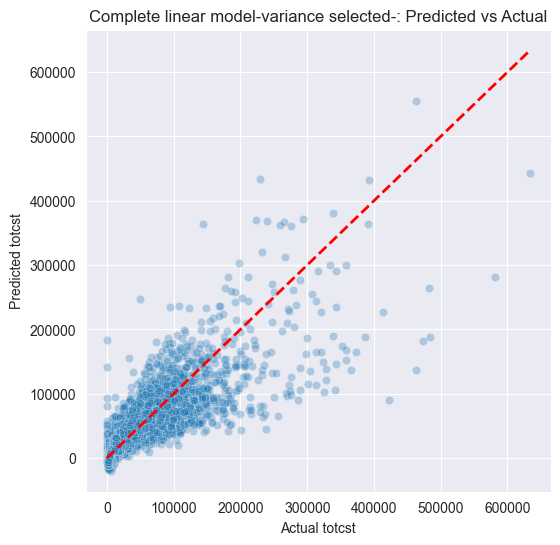


LASSO-selected Results:
Cross-validated R²: 0.715 ± 0.095
Cross-validated MSE: 619930647.93


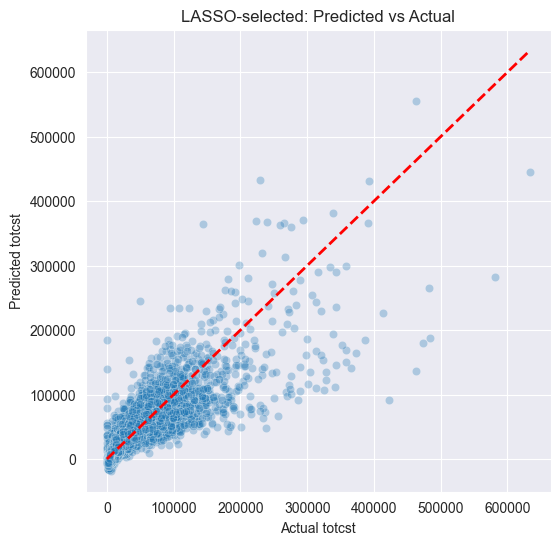


Stepwise-selected Results:
Cross-validated R²: 0.721 ± 0.091
Cross-validated MSE: 614015732.32


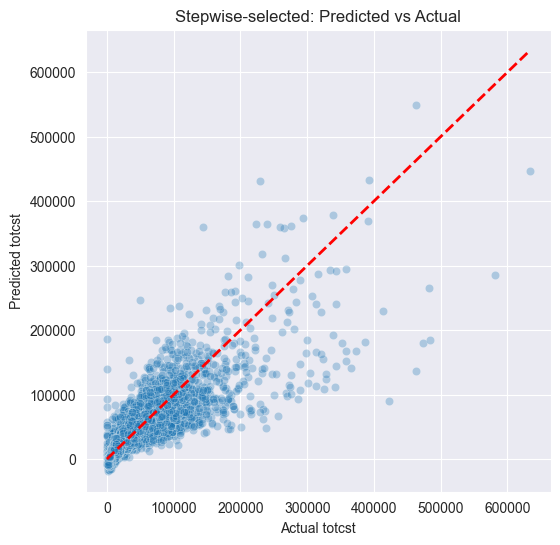

In [29]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the reduced datasets
X_full=X_selected
X_lasso = X_encoded[lasso_selected_features]
X_stepwise = X_encoded[stepwise_selected_features]

# Define helper function
def evaluate_and_plot(X, y, model_name="Model"):
    lr = LinearRegression()

    # Cross-validated R² scores
    r2_scores = cross_val_score(lr, X, y, cv=5, scoring='r2')

    # Cross-validated predictions for plotting & MSE
    preds = cross_val_predict(lr, X, y, cv=5)

    mse = mean_squared_error(y, preds)
    mean_r2 = np.mean(r2_scores)
    std_r2 = np.std(r2_scores)

    print(f"\n{model_name} Results:")
    print(f"Cross-validated R²: {mean_r2:.3f} ± {std_r2:.3f}")
    print(f"Cross-validated MSE: {mse:.2f}")

    # Plot predicted vs actual
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=y, y=preds, alpha=0.3)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    plt.xlabel("Actual totcst")
    plt.ylabel("Predicted totcst")
    plt.title(f"{model_name}: Predicted vs Actual")
    plt.show()

    return mean_r2, mse

# Run for Full-model
r2_lasso, mse_lasso = evaluate_and_plot(X_full, y, model_name="Complete linear model-variance selected-")

# Run for LASSO-selected
r2_lasso, mse_lasso = evaluate_and_plot(X_lasso, y, model_name="LASSO-selected")

# Run for Stepwise-selected
r2_stepwise, mse_stepwise = evaluate_and_plot(X_stepwise, y, model_name="Stepwise-selected")



LASSO-selected Results:
Cross-validated R²: 0.711 ± 0.096
Cross-validated MSE: 629661748.79


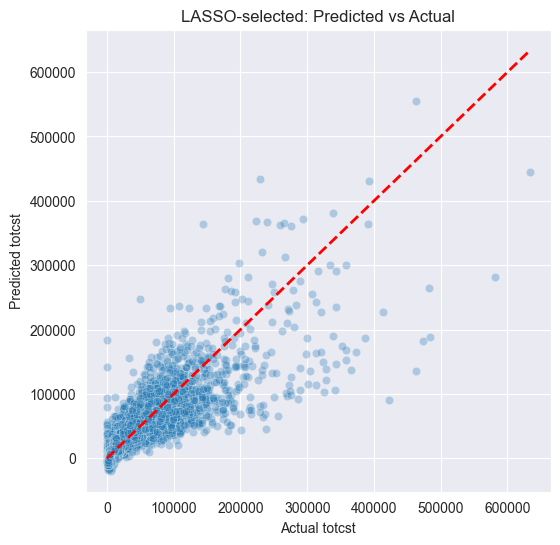

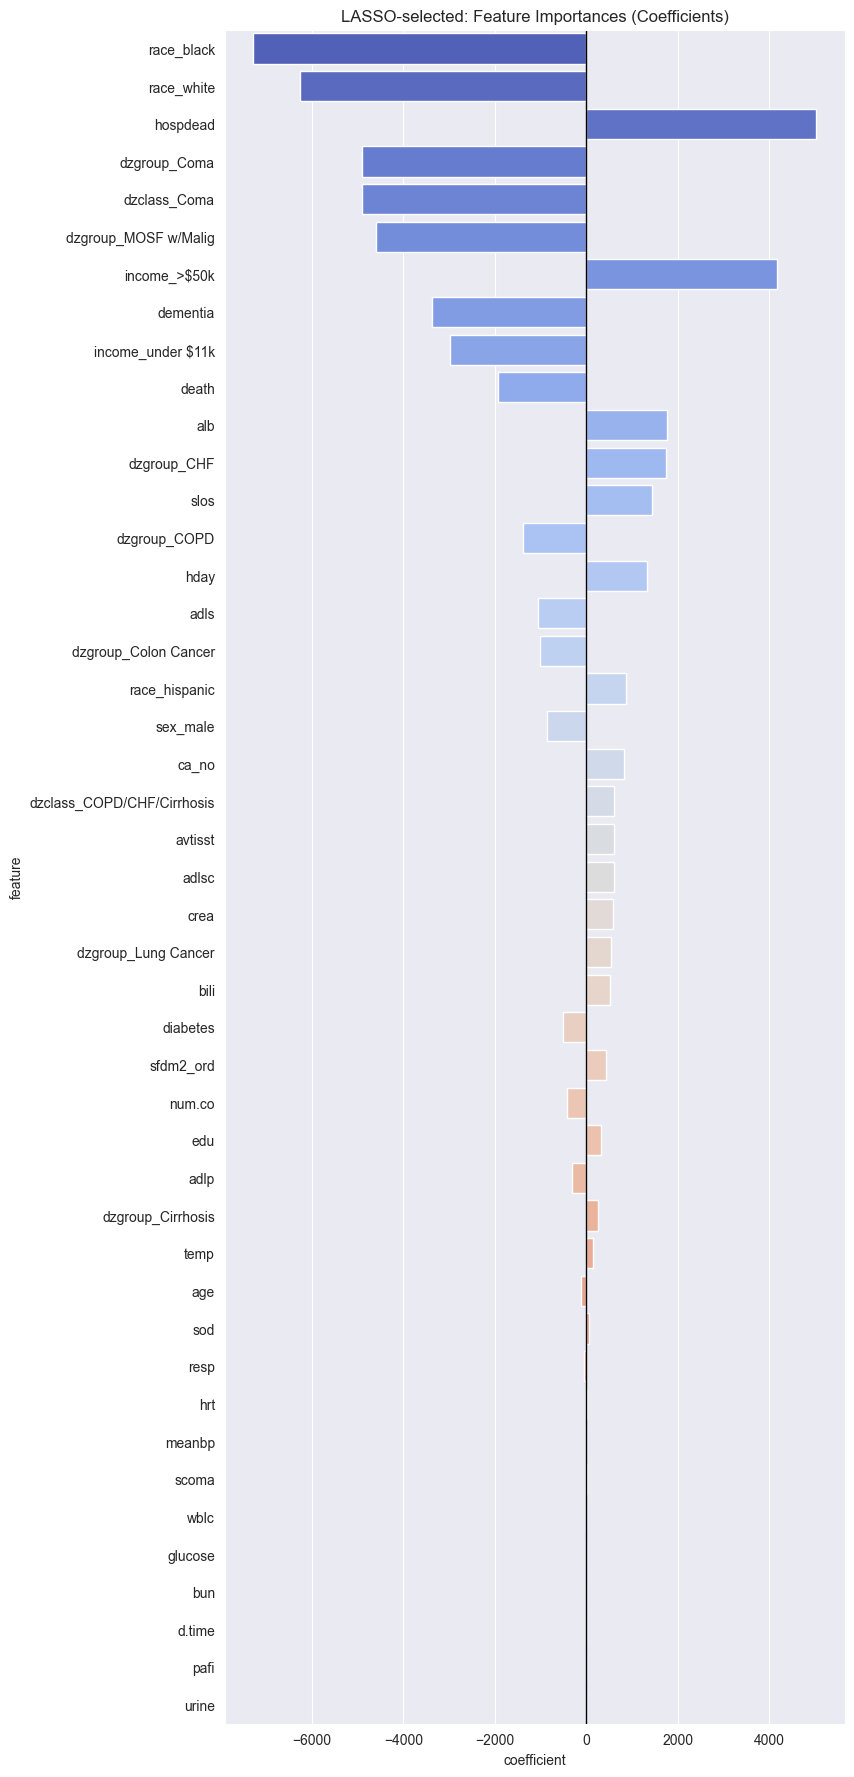


Stepwise-selected Results:
Cross-validated R²: 0.721 ± 0.091
Cross-validated MSE: 614015732.32


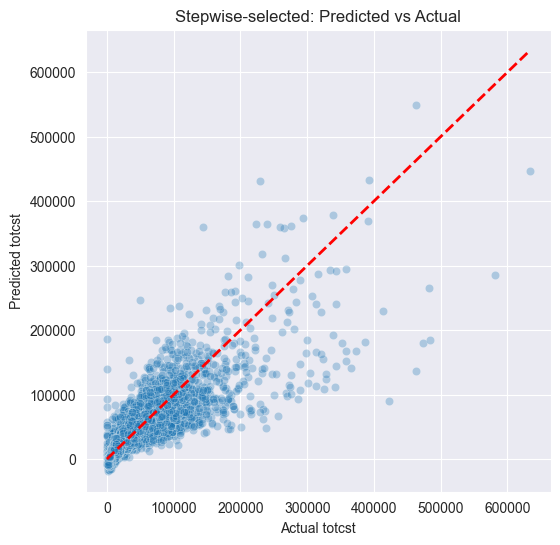

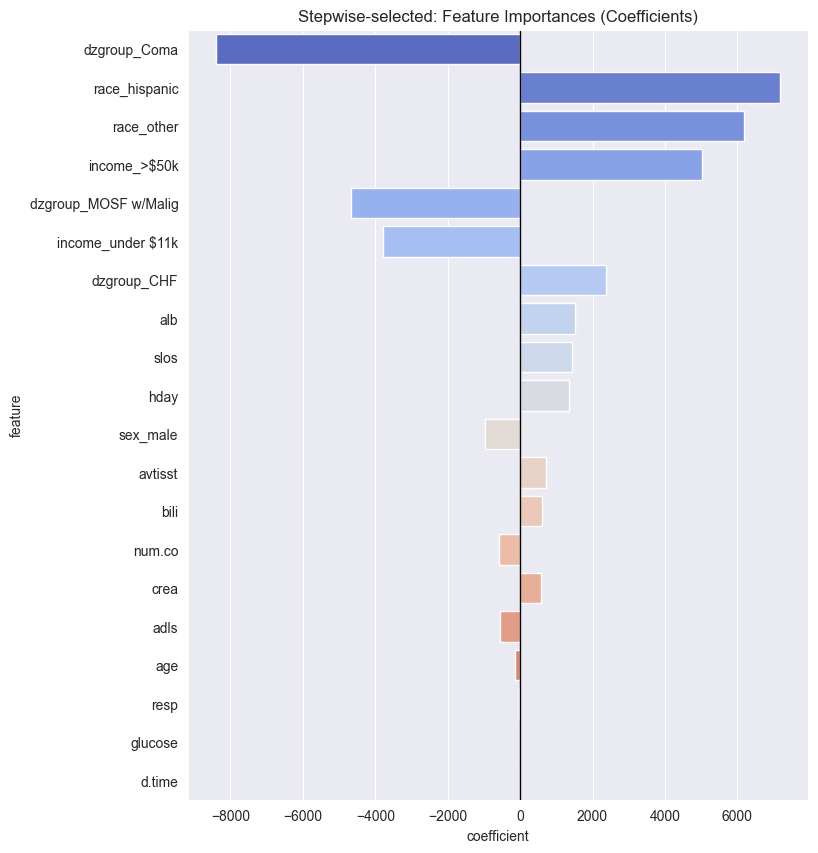

In [21]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_and_plot(X, y, feature_names, model_name="Model"):
    lr = LinearRegression()

    # Cross-validated R² scores
    r2_scores = cross_val_score(lr, X, y, cv=5, scoring='r2')
    preds = cross_val_predict(lr, X, y, cv=5)

    mse = mean_squared_error(y, preds)
    mean_r2 = np.mean(r2_scores)
    std_r2 = np.std(r2_scores)

    print(f"\n{model_name} Results:")
    print(f"Cross-validated R²: {mean_r2:.3f} ± {std_r2:.3f}")
    print(f"Cross-validated MSE: {mse:.2f}")

    # Scatter plot: predicted vs actual
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=y, y=preds, alpha=0.3)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    plt.xlabel("Actual totcst")
    plt.ylabel("Predicted totcst")
    plt.title(f"{model_name}: Predicted vs Actual")
    plt.show()

    # Fit on full data for coefficients
    lr.fit(X, y)
    coefs = lr.coef_
    coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefs})
    coef_df['abs_coef'] = coef_df['coefficient'].abs()
    coef_df = coef_df.sort_values(by='abs_coef', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(8, max(4, len(coef_df) // 2)))
    sns.barplot(
    x='coefficient',
    y='feature',
    data=coef_df,
    hue='feature',   # explicitly pass the `y` as hue
    dodge=False,
    palette='coolwarm',
    legend=False)

    plt.title(f"{model_name}: Feature Importances (Coefficients)")
    plt.axvline(0, color='k', lw=1)
    plt.show()

    return mean_r2, mse

# Prepare reduced datasets
X_lasso = X_encoded[lasso_selected_features]
X_stepwise = X_encoded[stepwise_selected_features]

# Run for LASSO-selected
r2_lasso, mse_lasso = evaluate_and_plot(
    X_lasso, y,
    feature_names=lasso_selected_features,
    model_name="LASSO-selected"
)

# Run for Stepwise-selected
r2_stepwise, mse_stepwise = evaluate_and_plot(
    X_stepwise, y,
    feature_names=stepwise_selected_features,
    model_name="Stepwise-selected"
)


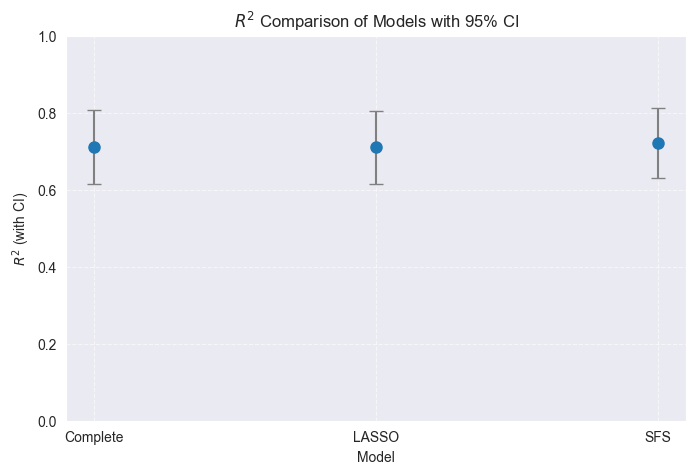

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Example results — replace these with your actual values:
media_complete = 0.711
L_complete = 0.711 - 0.096
U_complete = 0.711 + 0.096

media_LASSO = 0.710
L_LASSO = 0.710 - 0.095
U_LASSO = 0.710 + 0.095

media_SFS = 0.721
L_SFS = 0.721 - 0.091
U_SFS = 0.721 + 0.091

# Arrays
x = np.array([1, 2, 3])
y_results = np.array([media_complete, media_LASSO, media_SFS])
lower_bounds = np.array([L_complete, L_LASSO, L_SFS])
upper_bounds = np.array([U_complete, U_LASSO, U_SFS])

# Calculate error bars
yerr_lower = y_results - lower_bounds
yerr_upper = upper_bounds - y_results

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(
    x, y_results,
    yerr=[yerr_lower, yerr_upper],
    fmt='o', capsize=5, markersize=8, color='tab:blue', ecolor='gray'
)

plt.xticks(x, ['Complete', 'LASSO', 'SFS'])
plt.xlabel("Model")
plt.ylabel("$R^2$ (with CI)")
plt.title("$R^2$ Comparison of Models with 95% CI")
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0, 1)

plt.show()
